<a href="https://colab.research.google.com/github/Siddharthj2002/Text-Augmentation-using-LLMs/blob/master/Text_Augmentation_using_LLMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Augmentation using LLMs
Improving the performance on text classification by generating augmented text using LLMs for
under-represented categories



## Project Overview

### Authors
*   Sejal Agarwal
*   Siddharth Jain

### Reponsibilities

Siddharth will handle dataset creation, cleaning,
and augmentation, specifically making the AG
News dataset imbalanced by reducing instances
in the Science/Technology category and generating
synthetic data using GPT-4/BERT. Sejal will
focus on training classification models using Linear
Regression, SVM, and Transformers on both
the imbalanced and augmented datasets as well as
evaluating the model’s performance across several
metrics (accuracy, precision, recall, F1, confusion
matrix). Both members will collaborate on documentation
and visualization, using GitHub for version
control, and Google Docs & Overleaf for documentation.


### Motivation

We aim to explore how text augmentation with
LLMs can enhance classification performance, especially
in imbalanced datasets. Many textual
datasets have significant imbalances in the number
of examples for each class, which can cause
classification models to perform poorly on the minority
classes, leading to skewed predictions and
a lack of generalization. Imbalanced datasets are
an issue in real-world applications where the occurrence
of certain categories is naturally lower
than others. Improving recognition of these minority
categories is essential in fields like healthcare,
finance, and NLP applications for more accurate
decision-making.

## Installing Necessary Imports and Libraries

In [ ]:
# Install Hugging Face transformers and datasets library
!pip install transformers datasets

# Install scikit-learn for machine learning models and evaluation metrics
!pip install scikit-learn

# Install additional libraries for visualization and other utilities
!pip install matplotlib seaborn plotly

In [ ]:
# Import necessary libraries for handling data and models
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
import torch
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and using:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU instead.")

GPU is available and using: Tesla T4


## Data

### Loading the Dataset

In [ ]:
# Load the AG News dataset from Hugging Face
dataset = load_dataset("ag_news")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [ ]:
# Convert the dataset into a Pandas DataFrame for easier manipulation
train_data = pd.DataFrame(dataset['train'])
test_data = pd.DataFrame(dataset['test'])

# Display the column names and dataset size
print(f"Columns: {train_data.columns}")
print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")

# label_mapping = 0: 'World', 1: 'Sports', 2: 'Business', 3: 'Science/Technology'

# Display a few samples from the train dataset
train_data.head()

Columns: Index(['text', 'label'], dtype='object')
Training set size: 120000
Test set size: 7600


,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


**Label Mapping**

0: World

1: Sports

2: Business

3: Science/Technology

In [ ]:
# Check the class distribution in the training set
train_data['label'].value_counts().sort_index()

,count
label,
0,30000
1,30000
2,30000
3,30000


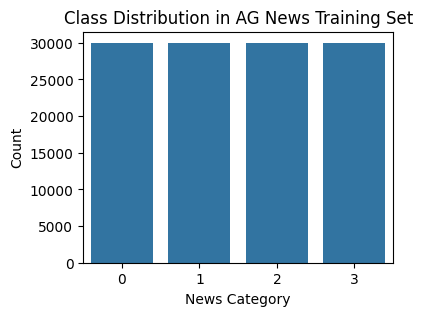

In [ ]:
# Plot class distribution in the training set
plt.figure(figsize=(4, 3))
sns.countplot(x='label', data=train_data)
plt.title('Class Distribution in AG News Training Set')
plt.xlabel('News Category')
plt.ylabel('Count')
plt.show()

### Data Preprocessing

**Text Cleaning**

In [ ]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Define stop words
stop_words = set(stopwords.words('english'))

# Text cleaning function
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply cleaning
train_data['text_cleaned'] = train_data['text'].apply(clean_text)
test_data['text_cleaned'] = test_data['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Removing Duplicates and Null Values**

In [ ]:
# Remove duplicates
train_data.drop_duplicates(subset=['text_cleaned'], inplace=True)

# Remove rows with null values
train_data.dropna(subset=['text_cleaned'], inplace=True)

**Creating Class Imbalance**

In [ ]:
# Reduce Science/Technology class instances by 70%
sci_tech_data = train_data[train_data['label'] == 3]
sci_tech_reduced = sci_tech_data.sample(frac=0.3, random_state=42)  # Keep 30%

# Reduce Business class instances by 40%
business_data = train_data[train_data['label'] == 2]
business_reduced = business_data.sample(frac=0.6, random_state=42)  # Keep 60%

# Combine the reduced classes with the rest of the dataset
train_data_imbalanced = pd.concat([
    train_data[train_data['label'] != 3],  # Exclude Science/Technology
    train_data[train_data['label'] != 2],  # Exclude Business
    sci_tech_reduced,                      # Add reduced Science/Technology
    business_reduced                       # Add reduced Business
])

# Check the new class distribution
print(train_data_imbalanced['label'].value_counts())

label
0    59916
1    59914
2    47842
3    38831
Name: count, dtype: int64


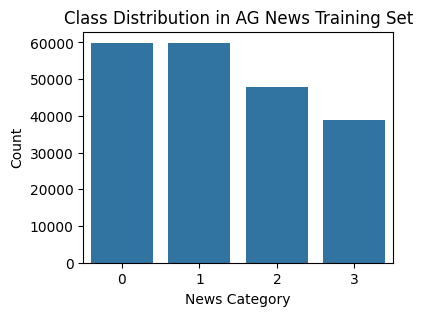

In [ ]:
# Plot class distribution in the training set
plt.figure(figsize=(4, 3))
sns.countplot(x='label', data=train_data_imbalanced)
plt.title('Class Distribution in AG News Training Set')
plt.xlabel('News Category')
plt.ylabel('Count')
plt.show()